# **Build Object Detection App (TensorFlow 1.x)**
**TRAIN AN OBJECT DETECTION MODEL FOR A CUSTOM DATASET AND CONVERT IT TO TFLITE MODEL FOR ANDROID / iOS / IoT DEVICES (TensorFlow 1.x)**


This notebook is part of this [blog post](https://techzizou.com/build-an-android-app-for-object-detection-tensorflow-1-x-complete-tutorial/)



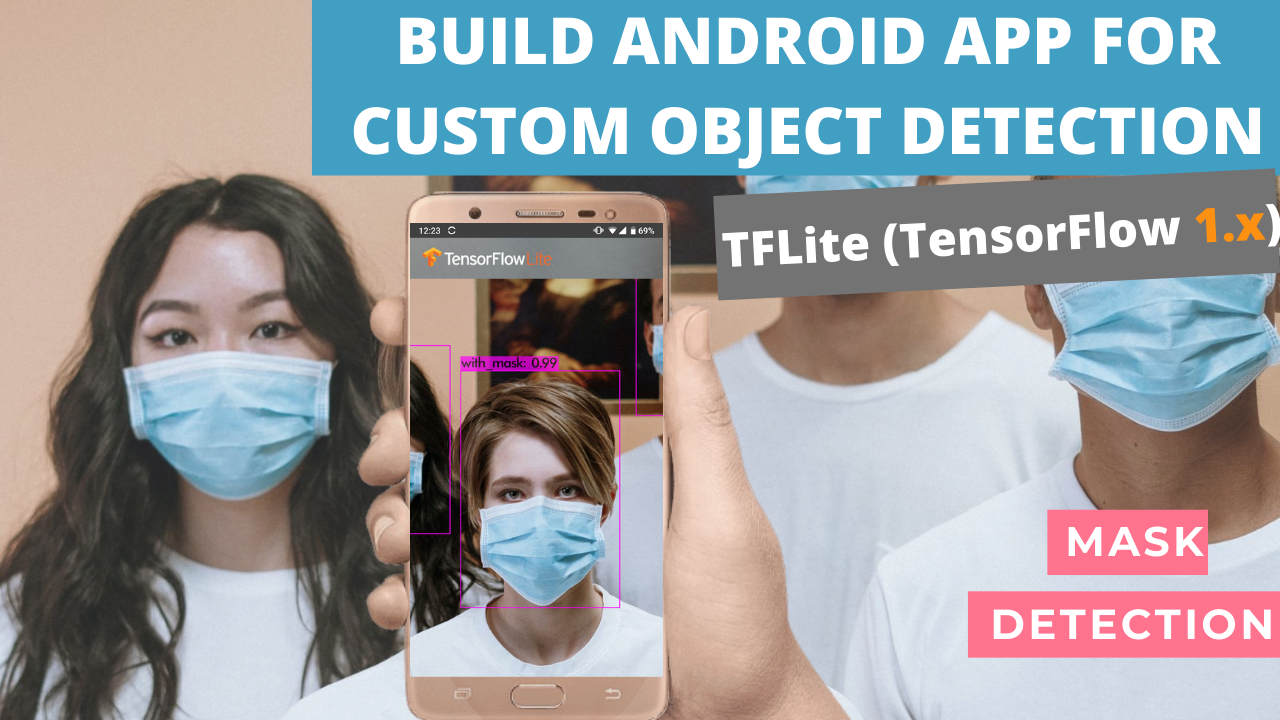


## **ROADMAP**


* Collect the dataset of images and label them to get their xml files.

* Install the TensorFlow Object Detection API.

* Generate the TFRecord files required for training. (need generate_tfrecord.py script and csv files for this)

* Edit the model pipeline config file and download the pre-trained model checkpoint.

* Train and evaluate the model.

* Export and convert the model into TFlite(TensorFlow Lite) format.

* Deploy the TFlite model on Android / iOS / IoT devices.







# **1) Install tensorflow 1.x**


In [ ]:
!pip install tensorflow==1.15


In [ ]:
import tensorflow as tf
print(tf.__version__)

# **2) Import dependencies**

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

# **3) Create *`customTF1`*, *`training`* and *`data`* folders in your google drive**
Create a folder named ***customTF1*** in your google drive.

Create another folder named ***training*** inside the ***customTF1*** folder
(***training*** folder is where the checkpoints will be saved during training)

Create another folder named ***data*** inside the ***customTF1*** folder.


# **4) Create and upload your image files and xml files.**
 Create a folder named ***images*** for your custom dataset images and create another folder named ***annotations*** for its corresponding xml files.
 
 Next, create their zip files and upload them to the ***customTF1*** folder in your drive.



 **<ins>NOTE</ins>**: Make sure all the image files have extension as ".jpg" only.
 Other formats like ".png" , ".jpeg" or even ".JPG" will give errors since the generate_tfrecord and xml_to_csv scripts here have only ".jpg" in them






 ## **Collecting Images Dataset and labeling them to get their PASCAL_VOC XML annotations**
For Datasets, you can check out my Dataset Sources at the bottom of this article in the credits section. You can use any software for labeling like the labelImg tool.

Read this [article](https://techzizou.com/dataset-labeling-annotation-tutorial-for-beginners/) to know more about collecting datasets and labeling process.


# **5) Upload the *`generate_tfrecord.py`* file to the *`customTF1`* folder on your drive.**


You can find the generate_tfrecord.py file [here](https://github.com/techzizou/Train-Object-Detection-Model-TF-1.x)

#**6) Mount drive and link your folder**

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

#list contents in your drive
!ls /mydrive

# **7) Clone the TensorFlow models git repository & Install TensorFlow Object Detection API**





In [ ]:
# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf1/setup.py .  
!python -m pip install .


# **8) Test the model builder**


In [ ]:
# testing the model builder
!python object_detection/builders/model_builder_tf1_test.py

# **9) Navigate to *`/mydrive/customTF1/data/`* and unzip the *`images.zip`* and *`annotations.zip`* files into the *`data`* folder**



In [ ]:
%cd /mydrive/customTF1/data/

# unzip the datasets and their contents so that they are now in /mydrive/customTF1/data/ folder
!unzip /mydrive/customTF1/images.zip -d .
!unzip /mydrive/customTF1/annotations.zip -d .

# **10) Create `test_labels` & `train_labels`**
Current working directory is /mydrive/customTF1/data/

Divide annotations into test_labels(20%) and train_labels(80%).

In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
!ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/


# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls annotations/* | xargs -I{} mv {} train_labels/


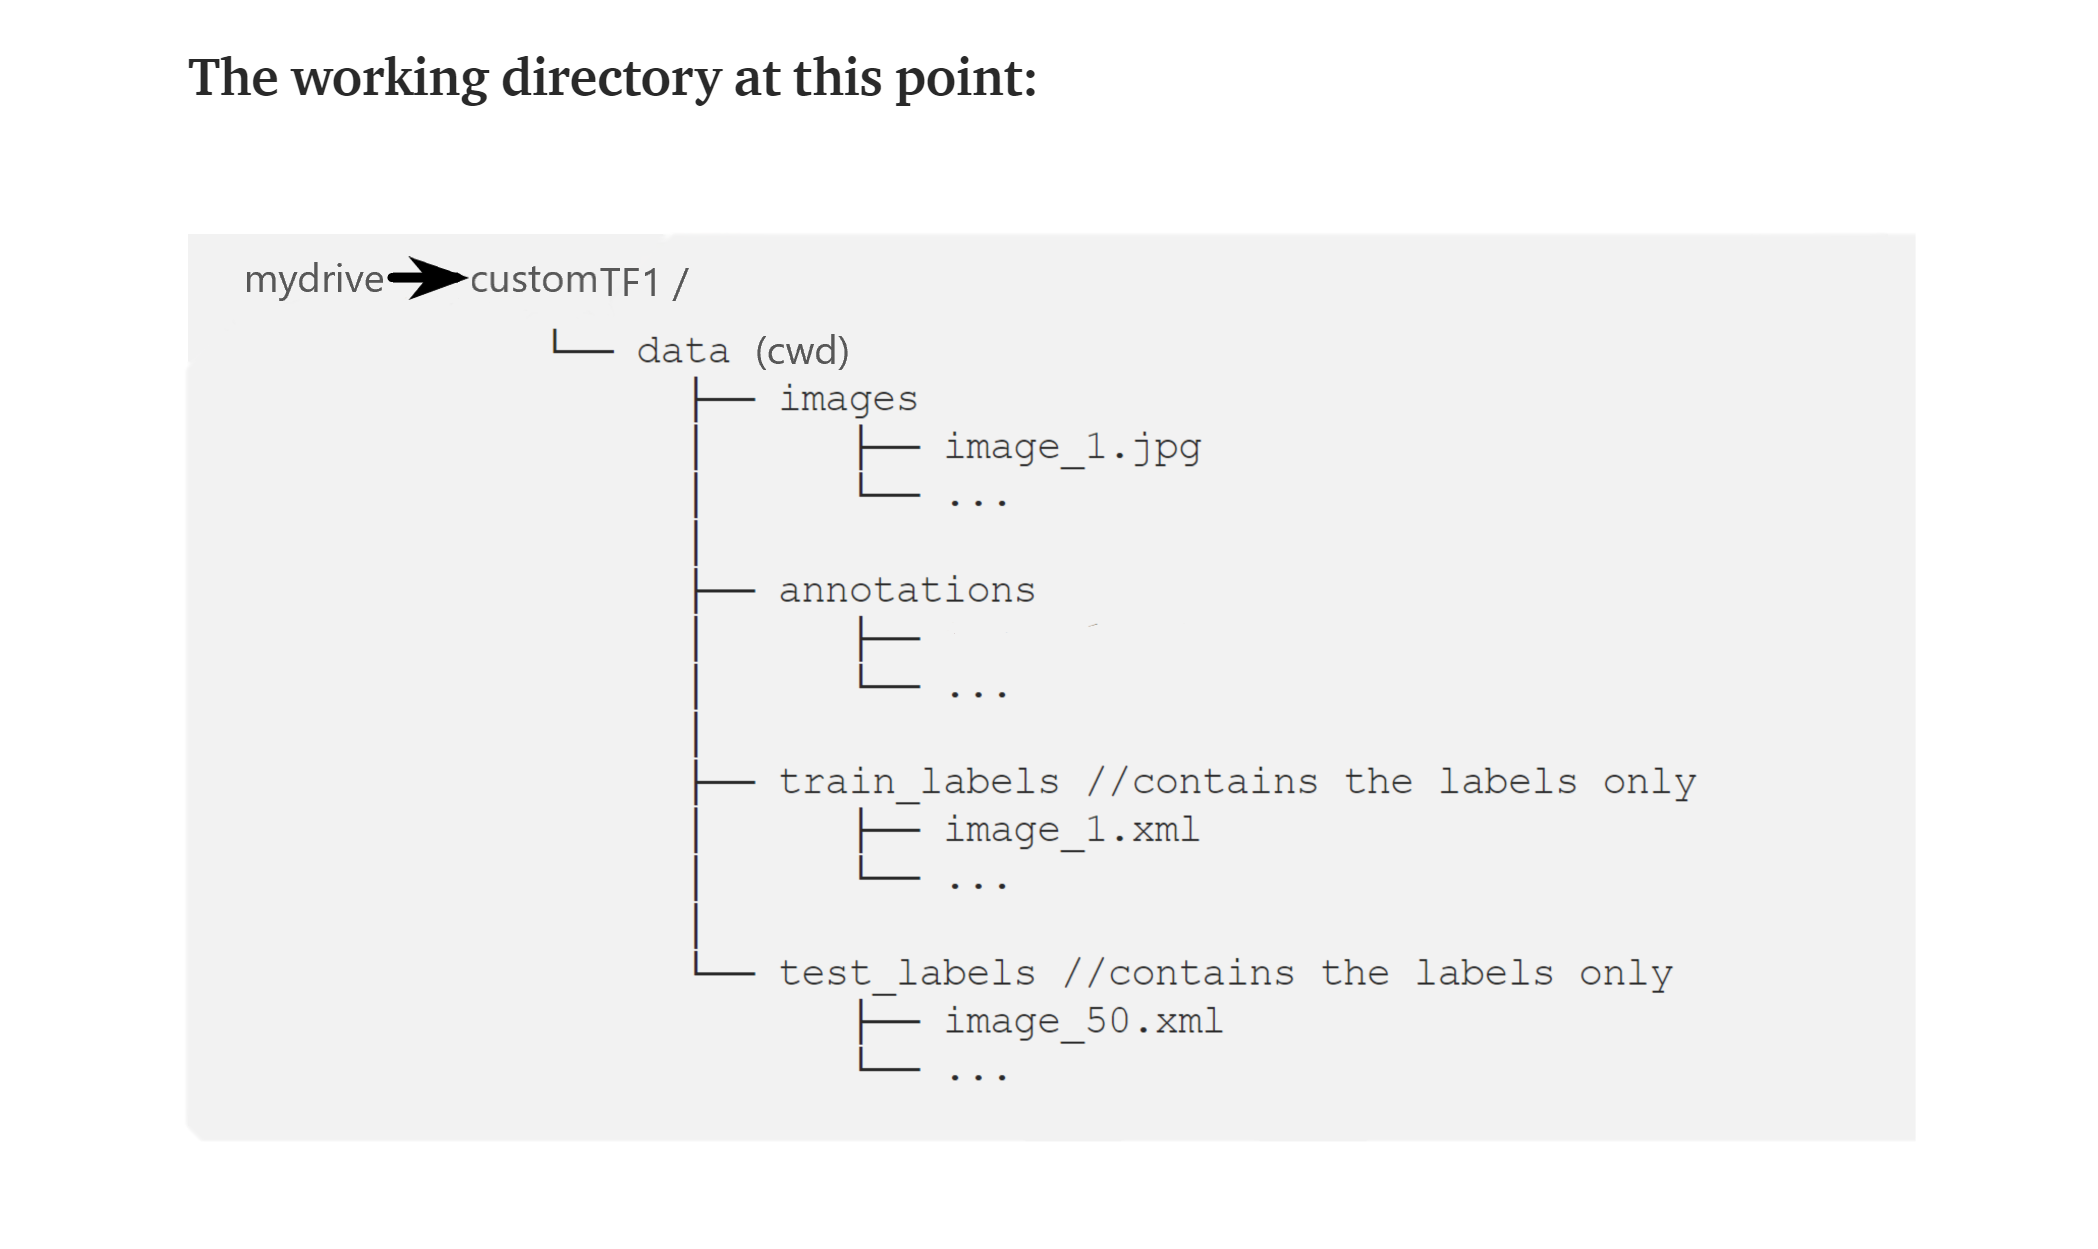

# **11) Create the CSV files and the "label_map.pbtxt" file**
Current working directory is /mydrive/customTF1/data/

Run xml_to_csv script below to create ***test_labels.csv*** and ***train_labels.csv***

This also creates the ***label_map.pbtxt*** file using the classes mentioned in the xml files. 

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,       
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')

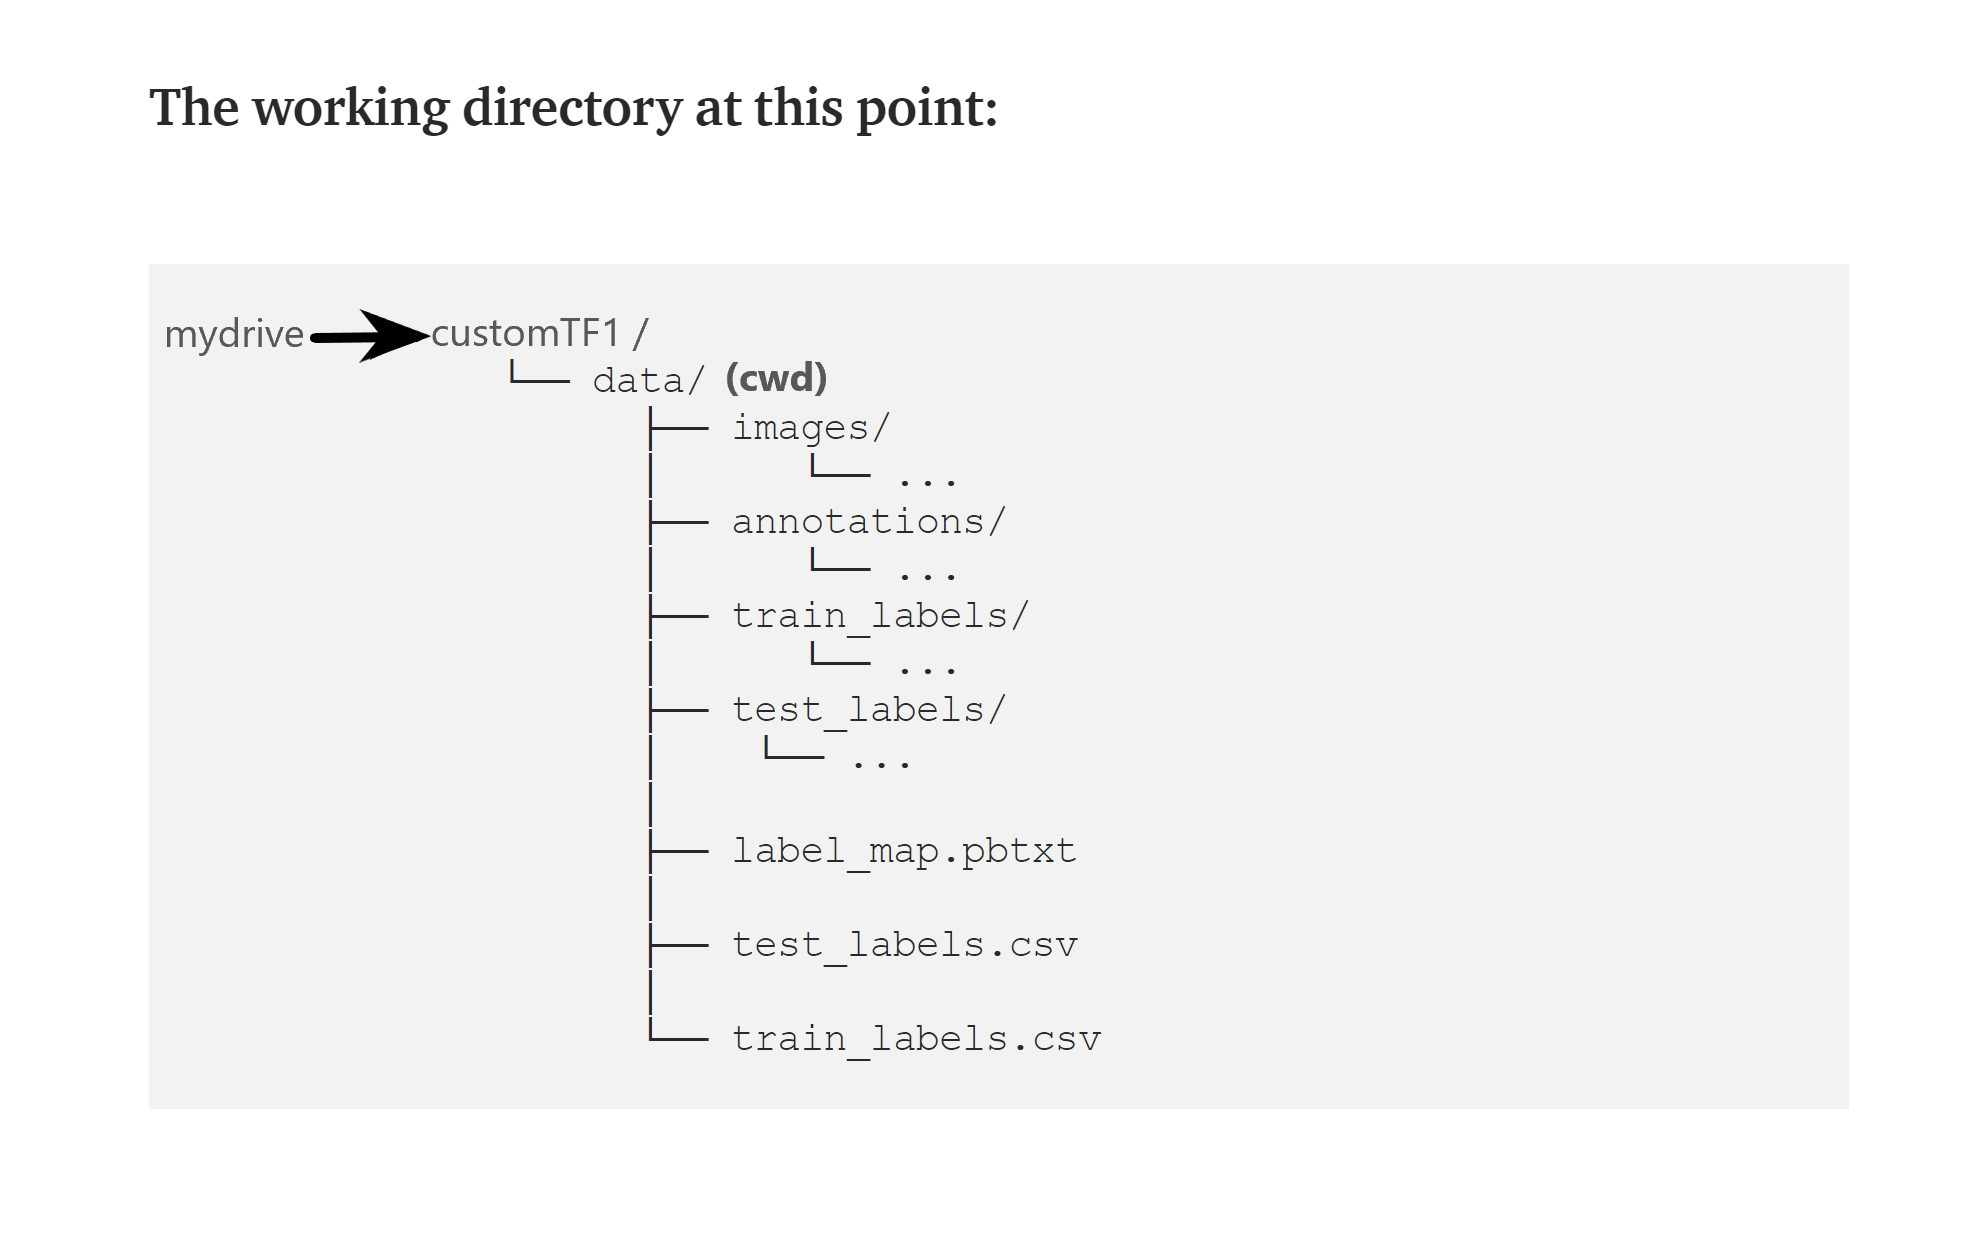

# **12) Create `train.record` & `test.record` files**

Current working directory is /mydrive/customTF1/data/

Run the *generate_tfrecord.py* script to create *train.record* and *test.record* files



In [ ]:
%cd /mydrive/customTF1/data/

In [ ]:
#Usage:  
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords

#FOR train.record
!python /mydrive/customTF1/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#FOR test.record
!python /mydrive/customTF1/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record

# **13) Download pre-trained model checkpoint** 

Current working directory is /mydrive/customTF1/data/

Download **ssd_mobilenet_v2_coco_2018_03_29.tar.gz** into the ***data*** folder & unzip it.

A list of detection checkpoints for tensorflow 1.x can be found [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md).


In [ ]:
#Download the pre-trained model ssd_mobilenet_v2_coco_2018_03_29.tar.gz into the data folder & unzip it.

!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!tar -xzvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

# **14) Get the model pipeline `config` file, make changes to it and put it inside the *`data`* folder**

Download **ssd_mobilenet_v2_coco.config** from ***/content/models/research/object_detection/samples/configs/*** folder. Make the required changes to it and upload it to the ***/mydrive/customTF1/data*** folder.

**OR**

Edit the config file from ***/content/models/research/object_detection/samples/configs/*** in colab and copy the edited config file to the ***/mydrive/customTF1/data*** folder.

You can also find the pipeline config file inside the model checkpoint folder we just downloaded in the previous step.


**You need to make the following changes:**
*   change ***num_classes*** to number of your classes.
*   change ***test.record*** path, ***train.record*** path & ***labelmap*** path to the paths where you have created these files (paths should be relative to your current working directory while training).
* change ***fine_tune_checkpoint*** to the path where the downloaded checkpoint from step 13 is. 
* change ***fine_tune_checkpoint_type*** with value **classification** or **detection** depending on the type.
* change ***batch_size*** to any multiple of 8 depending upon the capability of your GPU.
(eg:- 24,128,...,512).Mine is set to 24. 
* change ***num_steps*** to number of steps you want the detector to train. 



In [ ]:
#FOR METHOD 2 ,copy the confif file to the data folder 
!cp /content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config /mydrive/customTF1/data/

# **15) Load Tensorboard**

In [ ]:
#load tensorboard
%load_ext tensorboard 
%tensorboard --logdir '/content/gdrive/MyDrive/customTF1/training'

# **16) Train the model**






 ## Navigate to the ***object_detection*** folder in colab vm

In [ ]:
#FOR METHOD 2 ,change directory to object_detection
%cd /content/models/research/object_detection

## Training & evaluation using model_main.py

```
Run this command from the object_detection directory

PIPELINE_CONFIG_PATH={path to pipeline config file}
MODEL_DIR={path to model directory}
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

!python model_main.py --pipeline_config_path=${PIPELINE_CONFIG_PATH} --model_dir=${MODEL_DIR} --num_train_steps=${NUM_TRAIN_STEPS} --sample_1_of_n_eval_examples=${SAMPLE_1_OF_N_EVAL_EXAMPLES} --alsologtostderr

```



where **{PIPELINE_CONFIG_PATH}** points to the pipeline config and 
**{MODEL_DIR}** points to the directory in which training checkpoints and events will be written. Note that this binary will interleave both training and evaluation.

**NOTE**: For best results, you should stop the training when the loss is less than 1 if possible, else train the model until the loss does not show any significant change for a while. 



In [ ]:
#For Training and Evaluation

!python model_main.py --pipeline_config_path=/mydrive/customTF1/data/ssd_mobilenet_v2_coco.config --model_dir=/mydrive/customTF1/training --alsologtostderr

### <u>TROUBLESHOOTING</u>
If you get a numpy error like "Cannot convert a symbolic Tensor (cond_2/strided_slice:0) to a numpy array" , you can fix it by downgrading your numpy version, uninstalling and installing pycocotools. Run the 3 commands below:

**!pip install numpy==1.19.5**

**!pip uninstall pycocotools**

**!pip install pycocotools**


## **RETRAINING THE MODEL** ( in case you get disconnected )


If you get disconnected or lose your session on colab vm, you can start your training where you left off as the checkpoint is saved on your drive inside the ***training*** folder. To restart the training simply run **steps 1, 2, 6, 7, 8, 15, and 16.**

Note that since we have all the files required for training like the record files,our edited pipeline config file,the labelmap file and the model checkpoint folder, therefore we do not need to create these again.

 We just need to make one change in our pipeline config file.

Change **fine_tune_checkpoint** to where your latest trained checkpoints have been written.
``` 
fine_tune_checkpoint: "/mydrive/customTF1/training/model.ckpt-xxxx" (where model.ckpt-xxxx is the latest checkpoint)

```




# **17) Test your trained model**



## Export inference graph

Current working directory is /content/models/research/object_detection

In [ ]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path /mydrive/customTF1/data/ssd_mobilenet_v2_coco.config --trained_checkpoint_prefix /mydrive/customTF1/training/model.ckpt-168158 --output_directory /mydrive/customTF1/data/inference_graph

## Test your trained Object Detection model on images

Current working directory is /content/models/research/object_detection




In [ ]:
#navigate to object_detection folder
%cd /content/models/research/object_detection

In [ ]:
# Different font-type for labels text.(This step is optional)
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 50)/" visualization_utils.py
%cd ..

In [ ]:
# RUNNING INFERENCE
import numpy as np
import os
import cv2
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from google.colab.patches import cv2_imshow
from collections import defaultdict
from io import StringIO
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Change these values for the model used
num_classes = 2 # Change this value to the number of classes of the model
IMAGE_SIZE = (12, 8) # Output display size as you want

# Use images in test dir
IMAGE_DIR = "/mydrive/images"
IMAGE_PATHS = []
for file in os.listdir(IMAGE_DIR):
    if file.endswith(".jpg") or file.endswith(".png"):
        IMAGE_PATHS.append(os.path.join(IMAGE_DIR, file))

# Set paths to the trained model
PATH_TO_LABELS = '/content/gdrive/MyDrive/customTF1/data/label_map.pbtxt'
PATH_TO_CKPT = os.path.join(os.path.abspath("/content/gdrive/MyDrive/customTF1/data/inference_graph"), "frozen_inference_graph.pb")


# Set tensorflow graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Set categories
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Convert input image to a numpy array
def load_image_to_numpy(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Inference pipeline
def run_inference(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, .5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

# Run the inference for each image
for image_path in IMAGE_PATHS:
    image = Image.open(image_path)
    # Conver the image to numpy array
    image_np = load_image_to_numpy(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Perform the interence
    output_dict = run_inference(image_np, detection_graph)
    # Visualize
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=20,
        min_score_thresh=0.1)
    plt.figure(figsize=IMAGE_SIZE, dpi=200)
    plt.axis("off")
    plt.imshow(image_np)


# **18) Export ssd tflite graph**

Current working directory is /content/models/research/object_detection

In [ ]:
#Change xxxxxx in the trained_checkpoint_prefix's model.ckpt-xxxxxx to point to your latest checkpoint

!python export_tflite_ssd_graph.py --pipeline_config_path /mydrive/customTF1/data/ssd_mobilenet_v2_coco.config --trained_checkpoint_prefix /mydrive/customTF1/training/model.ckpt-xxxxxx --output_directory /mydrive/customTF1/data/tflite --add_postprocessing_op=true 

# **19) Convert tflite graph to tflite model**

## Check input and output tensor names

In [ ]:
import tensorflow as tf
gf = tf.GraphDef()   
m_file = open('/mydrive/customTF1/data/tflite/tflite_graph.pb','rb')
gf.ParseFromString(m_file.read())

for n in gf.node:
    print( n.name )

## Convert to tflite

In [ ]:
#For FLOAT 
!tflite_convert --graph_def_file /mydrive/customTF1/data/tflite/tflite_graph.pb --output_file /mydrive/customTF1/data/tflite/detect.tflite --output_format TFLITE --input_shapes 1,300,300,3 --input_arrays normalized_input_image_tensor --output_arrays 'TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type FLOAT --allow_custom_ops 

#FOR QUANTIZED_UINT8 
#!tflite_convert --graph_def_file=/mydrive/customTF1/data/tflite/tflite_graph.pb --output_file=/mydrive/customTF1/data/tflite/detect.tflite --output_format=TFLITE --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=QUANTIZED_UINT8 --default_ranges_min=0 --default_ranges_max=255 --mean_values=128 --std_dev_values=128 --change_concat_input_ranges=false --allow_custom_ops

# **20) Create TFLite with metadata**


In [ ]:
pip install tflite_support_nightly

In [ ]:
%cd /mydrive/customTF1/data/
%cd tflite/
!mkdir tflite_with_metadata
%cd ..

In [ ]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata
import flatbuffers
import os
from tensorflow_lite_support.metadata import metadata_schema_py_generated as _metadata_fb
from tensorflow_lite_support.metadata.python import metadata as _metadata
from tensorflow_lite_support.metadata.python.metadata_writers import metadata_info
from tensorflow_lite_support.metadata.python.metadata_writers import metadata_writer
from tensorflow_lite_support.metadata.python.metadata_writers import writer_utils

ObjectDetectorWriter = object_detector.MetadataWriter

_MODEL_PATH = "/mydrive/customTF1/data/tflite/detect.tflite"
_LABEL_FILE = "/mydrive/customTF1/data/labelmap.txt"
_SAVE_TO_PATH = "/mydrive/customTF1/data/tflite/tflite_with_metadata/detect.tflite"

writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [127.5], [127.5], [_LABEL_FILE])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

# Verify the populated metadata and associated files.
displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "SSD_Detector"
model_meta.description = (
    "Identify which of a known set of objects might be present and provide "
    "information about their positions within the given image or a video "
    "stream.")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Creates outputs info.
output_location_meta = _metadata_fb.TensorMetadataT()
output_location_meta.name = "location"
output_location_meta.description = "The locations of the detected boxes."
output_location_meta.content = _metadata_fb.ContentT()
output_location_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.BoundingBoxProperties)
output_location_meta.content.contentProperties = (
    _metadata_fb.BoundingBoxPropertiesT())
output_location_meta.content.contentProperties.index = [1, 0, 3, 2]
output_location_meta.content.contentProperties.type = (
    _metadata_fb.BoundingBoxType.BOUNDARIES)
output_location_meta.content.contentProperties.coordinateType = (
    _metadata_fb.CoordinateType.RATIO)
output_location_meta.content.range = _metadata_fb.ValueRangeT()
output_location_meta.content.range.min = 2
output_location_meta.content.range.max = 2

output_class_meta = _metadata_fb.TensorMetadataT()
output_class_meta.name = "category"
output_class_meta.description = "The categories of the detected boxes."
output_class_meta.content = _metadata_fb.ContentT()
output_class_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_class_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())
output_class_meta.content.range = _metadata_fb.ValueRangeT()
output_class_meta.content.range.min = 2
output_class_meta.content.range.max = 2
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labelmap.txt")
label_file.description = "Label of objects that this model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_VALUE_LABELS
output_class_meta.associatedFiles = [label_file]

output_score_meta = _metadata_fb.TensorMetadataT()
output_score_meta.name = "score"
output_score_meta.description = "The scores of the detected boxes."
output_score_meta.content = _metadata_fb.ContentT()
output_score_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_score_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())
output_score_meta.content.range = _metadata_fb.ValueRangeT()
output_score_meta.content.range.min = 2
output_score_meta.content.range.max = 2

output_number_meta = _metadata_fb.TensorMetadataT()
output_number_meta.name = "number of detections"
output_number_meta.description = "The number of the detected boxes."
output_number_meta.content = _metadata_fb.ContentT()
output_number_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_number_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())

# Creates subgraph info.
group = _metadata_fb.TensorGroupT()
group.name = "detection result"
group.tensorNames = [
    output_location_meta.name, output_class_meta.name,
    output_score_meta.name
]
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [
    output_location_meta, output_class_meta, output_score_meta,
    output_number_meta
]
subgraph.outputTensorGroups = [group]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

# **21) Download the TFLite model and adjust the TFLite Object Detection sample app from TensorFlow's GitHub**
For the Next steps read the entire [blog post](https://techzizou.com/build-an-android-app-for-object-detection-tensorflow-1-x-complete-tutorial/).

# **MY GITHUB** 


*   [Object Detection using Tensorflow 1.x](https://github.com/techzizou/Train-Object-Detection-Model-TF-1.x)

# **♕ TECHZIZOU ♕** 





# 🖖